In [127]:
# Importing essential packages for numerical computations and statistical modeling
import numpy as np
from scipy.stats import binom

# **Initial Revenue and Cost Analysis**

**Assumptions and Conditions - Parameters**

(5 Seats Overbooking Strategy)

This section defines the initial parameters of the model, including the number of days before the flight (T), the number of seats available for the main cabin (coach_seats) and the first-class cabin (first_seats), the probabilities of passengers showing up for both classes, ticket prices, and sales probabilities for different prices.

In [128]:
"""
airline

two types of tickets:
- main cabin
- first class

overbooking:
- only allowed for main cabin
- overbooked main cabin can use first class if there are spaces left
    -> This will incur a cost for the airline, cost_1
- overbooked that don't have a seat available:
    -> This will incur another cost for the airline cost_2

selling:
- everyday we can sell or not a ticket for each type
- we have to possible prices to charge, High or Low, for both types
- demand for each class is independent
    - each type of ticket has their own probability distribution
    - when first class is sold out, probability of sale in coach is +3%
"""

T=365  # 365 days before the plane departs
coach_seats = 100  # 100 seats for main cabin
first_seats = 20  # 20 seats for first class

coach_showup_prob = 0.95  # 95% prob of coach ticket holder to show up
first_showup_prob = 0.97  # 97% prob of first class ticket holder to show

coach_price_L = 300  # coach ticket low price
coach_price_H = 350  # coach ticket high price
first_price_L = 425  # first class ticket low price
first_price_H = 500  # first class ticket high price

# Coach Low and High sale probabilities
coach_L_sale_prob = 0.65
coach_H_sale_prob = 0.30

# First class Low and High sale probabilities
first_L_sale_prob = 0.08
first_H_sale_prob = 0.04

# price_combinations
price_comb = np.array([
    [coach_price_L, first_price_L],
    [coach_price_L, first_price_H],
    [coach_price_H, first_price_L],
    [coach_price_H, first_price_H]
])

prob_comb = np.array([
    [coach_L_sale_prob, first_L_sale_prob],
    [coach_L_sale_prob, first_H_sale_prob],
    [coach_H_sale_prob, first_L_sale_prob],
    [coach_H_sale_prob, first_H_sale_prob]
])

overbooking = 5  # number of seats we can overbook

upgrade_cost = 50  # cost of upgrading coach to first class
bump_cost = 425  # cost of leaving passenger on the ground

discount_rate = 0.17
daily_d =  1/(1+(discount_rate/365))

**Value Function**

The value function V, represented by a multi-dimensional array, is central to our model, storing expected profits for different states defined by coach and first-class seats, with an extra margin for overbooking. We also have a policy array selection
P to track pricing decisions, using a coded system for quick reference to various price combinations. These arrays, initialized to zeros, are dimensions of seating options and days until flight, setting up the structure for our dynamic programming analysis.

In [129]:
"""
Value Function V(coach_seats, first_class, t),
"""
V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
# For price selection:
# 0 = Lc - Lf
# 1 = Lc - Hf
# 2 = Hc - Lf
# 3 = Hc - Hf

coach_options = np.arange(coach_seats+overbooking+1)
first_options = np.arange(first_seats+1)

In [130]:
print("Dimensions - Coach Seats + Overbooking Options:", V.shape[0],
      ", First-Class Seats:", V.shape[1],
      ", Total Days Until Departure + 1:", V.shape[2])


Dimensions - Coach Seats + Overbooking Options: 106 , First-Class Seats: 21 , Total Days Until Departure + 1: 366


 The fill_terminal_value() function calculates the terminal values of the value function for time T, i.e., the day before the flight departure. These terminal values represent the expected earnings when there are no more days to sell tickets.

In [131]:
"""
Terminal Value for V(T)
"""
def fill_terminal_value():
    # For each pair scenario of coach and first class tickets sold
    for coach in coach_options:
        for first in first_options:
            # Each pair scenario of coach and first class that they show up
            # initialize value_fn
            value_fn = 0
            for showup_coach in range(coach+1):
                for showup_first in range(first+1):
                    # print(f'Scenario, coach tickets: {coach},\tfirst class tickets: {first},\tshowup_coach: {showup_coach},\tshowup_first: {showup_first}') ## Debugging purposes

                    # overbooking has occurred
                    if showup_coach > coach_seats:
                        overbook = showup_coach - coach_seats
                        free_seats_first = first_seats - showup_first
                        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

                        prob_scenario_coach = binom.pmf(showup_coach, coach, coach_showup_prob)
                        prob_scenario_first = binom.pmf(showup_first, first, first_showup_prob)
                        # Value function = (cost of upgrading to first class + cost of bumping of the plane) * probability of this scenario to happen
                        value_fn += -(upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first)) * prob_scenario_coach * prob_scenario_first
                    # no overbooking
                    else:
                        value_fn += 0


            V[coach][first][T] = value_fn

fill_terminal_value()

Here, the get_revenue_today() function is defined, which calculates the expected revenue for the current day, considering the number of seats sold so far, ticket prices, and sales probabilities.

In [132]:
# iterate through all combinations of p
coach = 100
first = 20

# if price is low low
p = price_comb[0]
prob = prob_comb[0]

def get_revenue_today(coach, first, ti, p, prob):
    """
    This function calculates the Value function for a defined number of:
    - coach tickets sold
    - first tickets sold
    - time period
    - probabilities
    """
    # check if we have both types of seats to sell
    if coach < (coach_seats + overbooking) and first < first_seats:
        #print('Tickets available for both')
        # Calculate revenue through all possible outcomes
        #           sell - sell                   sell - not sell                not sell - sell                not sell - not sell
        rev_today = (p[0]+p[1])*prob[0]*prob[1] + (p[0]+0)*prob[0]*(1-prob[1]) + (0+p[1])*(1-prob[0])*prob[1] + (0+0)*(1-prob[0])*(1-prob[1])

        # We don't know what will happen tomorrow
        #                   sell - sell                              sell - not sell                               not sell - sell                              not sell - not sell
        rev_tomorrow = V[coach+1][first+1][ti+1]*prob[0]*prob[1] + V[coach+1][first][ti+1]*prob[0]*(1-prob[1]) + V[coach][first+1][ti+1]*(1-prob[0])*prob[1] + V[coach][first][ti+1]*(1-prob[0])*(1-prob[1])

    # check if we have sold out first class
    elif coach < (coach_seats + overbooking) and first == first_seats:
        #print('Sold out first class')
        # Calculate revenue through all possible outcomes
        # first class sold out prob increases 3%
        #           sell                   not sell
        rev_today = p[0]*(prob[0]+0.03) + 0*(1-prob[0]-0.03)

        # We don't know what will happen tomorrow
        #                   sell                                  not sell
        rev_tomorrow = V[coach+1][first][ti+1]*(prob[0]+0.03) +  V[coach][first][ti+1]*(1-prob[0]-0.03)

    # check if we have sold out first class
    elif coach == (coach_seats + overbooking) and first < first_seats:
        #print('Sold out first coach')
        # Calculate revenue through all possible outcomes
        #           sell           not sell
        rev_today = p[1]*prob[1] + 0*(1-prob[1])

        # We don't know what will happen tomorrow
        #                       sell                               not sell
        rev_tomorrow = V[coach][first+1][ti+1]*prob[1] +  V[coach][first][ti+1]*(1-prob[1])

    # no seats available to sell
    else:
        #print('Sold out both')
        rev_today = 0
        rev_tomorrow = V[coach][first][ti+1]

    #print(f'Revenue today: {rev_today}, revenue_tomorrow: {rev_tomorrow}')
    return rev_today + daily_d*rev_tomorrow

print(get_revenue_today(coach, first, 363, p, prob))

204.00000000000003


In this section, the fill_value_function() function is implemented, which populates the value function V by stepping backward in time from the last day to the current day, considering all possible combinations of prices and seats sold.

In [133]:
"""
Fill up V(c, f, ti) going from last day to today
"""
def fill_value_function():
    # Go back in time :)
    for ti in reversed(range(T)):
        # loop through all pair scenario of coach and first class tickets sold
        # value function of coach and fairst prices option

        for coach in coach_options:
            for first in first_options:
                #print(f'coach: {coach}, first: {first}, ti: {ti}')
                value_options = [get_revenue_today(coach, first, ti, price_comb[i], prob_comb[i]) for i in range(len(price_comb))]
                # get value for each one of the possible decisions we have
                # Lc - Lf, Lc - Hf, Hc - Lf, Hc - Hf

                # get best value_option
                #print(value_options)
                #print(np.max(value_options))
                #print(np.argmax(value_options))
                V[coach][first][ti] = np.max(value_options)
                P_selection[coach][first][ti] = np.argmax(value_options)

fill_value_function()

In [134]:
# Print the expected discounted profit at the beginning of the selling period
print("Expected Discounted Profit:", V[0][0][0])

Expected Discounted Profit: 41886.158624195705


In [135]:
# Print the optimal price combination choice at the start of the selling period
print("Optimal Price Combination Choice at Start:", P_selection[0][0][0])


Optimal Price Combination Choice at Start: 2.0


(High price for coach tickets and low price for first class)

**6,7,...,15 seats overbooking strategy**

This portion of the code is evaluating the expected profits for varying levels of overbooking, ranging from 6 to 15 additional seats. For each overbooking scenario, it calculates the expected profit at the beginning of the selling period and stores the corresponding pricing policy.

In [136]:
overbooking_values_policy1 = np.arange(5,16)
expected_profits_policy1 = np.zeros(len(overbooking_values_policy1))
pricing_policy1 = {}

for i in range(len(overbooking_values_policy1)):

    overbooking = overbooking_values_policy1[i]
    V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
    P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
    # For price selection:
    # 0 = Lc - Lf
    # 1 = Lc - Hf
    # 2 = Hc - Lf
    # 3 = Hc - Hf

    coach_options = np.arange(coach_seats+overbooking+1)
    first_options = np.arange(first_seats+1)

    fill_terminal_value()
    fill_value_function()

    # Results
    expected_profits_policy1[i] = V[0][0][0]
    pricing_policy1[i] = P_selection
    print(f'Seats available for booking: {overbooking}, Expected profit: {V[0][0][0]}')


Seats available for booking: 5, Expected profit: 41886.158624195705
Seats available for booking: 6, Expected profit: 42011.22106044435
Seats available for booking: 7, Expected profit: 42085.53615582861
Seats available for booking: 8, Expected profit: 42122.167268762896
Seats available for booking: 9, Expected profit: 42134.62483034151
Seats available for booking: 10, Expected profit: 42132.900382350956
Seats available for booking: 11, Expected profit: 42123.66593558059
Seats available for booking: 12, Expected profit: 42111.029670478485
Seats available for booking: 13, Expected profit: 42097.41950987721
Seats available for booking: 14, Expected profit: 42084.111570352936
Seats available for booking: 15, Expected profit: 42071.74230930781


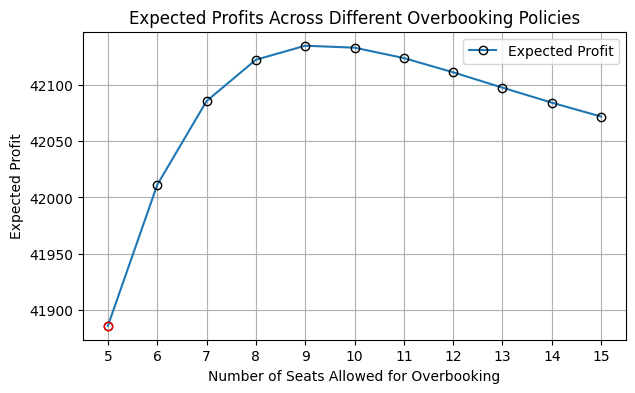

In [124]:
# Plotting the expected profits across different overbooking policies with the specified details.

plt.figure(figsize=(7, 4))

# Plotting all points with hollow center and colored border
plt.plot(overbooking_values_policy1, expected_profits_policy1, '-o', mfc='none', mec='black', label='Expected Profit')

# Highlighting the point at overbooking = 5 with a red color
plt.plot(overbooking_values_policy1[0], expected_profits_policy1[0], 'o', mfc='none', mec='r')

plt.title('Expected Profits Across Different Overbooking Policies')
plt.xticks(np.arange(5, 16, 1))
plt.xlabel('Number of Seats Allowed for Overbooking')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()


Maximum profit at 9 seats: 42134.62

# **New Policy**

This code introduces a new policy in the airline’s revenue management model that adds the option to not sell any coach tickets on a given day. It updates the pricing decision array to include scenarios where coach tickets are not sold, potentially directing demand to first-class or controlling the risk of overbooking. For each possible overbooking level, from zero additional seats up to twenty, the code recalculates the expected profits, considering this new no-sale coach policy. This approach allows the airline to strategically adjust daily sales tactics based on the remaining time and existing sales, aiming to optimize the expected discounted profit over the entire selling period. The results are then compared to the previous policy to determine the impact of this added flexibility on profitability.

In [76]:
"""
Here you need to create a copy of the function fill_value_function to include the new option,
also change price_comb, prob_comb, and P_selection will now include the two new options
"""
T=365  # 365 days before the plane departs
coach_seats = 100  # 100 seats for main cabin
first_seats = 20  # 20 seats for first class

# Add no coach sale scenario
price_comb_new = np.array([
    [coach_price_L, first_price_L],
    [coach_price_L, first_price_H],
    [coach_price_H, first_price_L],
    [coach_price_H, first_price_H],
    [0, first_price_L],  # No coach sale scenario, lower first class price
    [0, first_price_H]   # No coach sale scenario, higher first class price
])

prob_comb_new = np.array([
    [coach_L_sale_prob, first_L_sale_prob],
    [coach_L_sale_prob, first_H_sale_prob],
    [coach_H_sale_prob, first_L_sale_prob],
    [coach_H_sale_prob, first_H_sale_prob],
    [0, first_L_sale_prob],  # No coach sale scenario, lower first class sale probability
    [0, first_H_sale_prob]   # No coach sale scenario, higher first class sale probability
])

#V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))

def fill_terminal_value():
    # For each pair scenario of coach and first class tickets sold
    for coach in coach_options:
        for first in first_options:
            # Each pair scenario of coach and first class that they show up
            # initialize value_fn
            value_fn = 0
            for showup_coach in range(coach+1):
                for showup_first in range(first+1):
                    # print(f'Scenario, coach tickets: {coach},\tfirst class tickets: {first},\tshowup_coach: {showup_coach},\tshowup_first: {showup_first}') ## Debugging purposes

                    # overbooking has occurred
                    if showup_coach > coach_seats:
                        overbook = showup_coach - coach_seats
                        free_seats_first = first_seats - showup_first
                        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

                        prob_scenario_coach = binom.pmf(showup_coach, coach, coach_showup_prob)
                        prob_scenario_first = binom.pmf(showup_first, first, first_showup_prob)
                        # Value function = (cost of upgrading to first class + cost of bumping of the plane) * probability of this scenario to happen
                        value_fn += -(upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first)) * prob_scenario_coach * prob_scenario_first
                    # no overbooking
                    else:
                        value_fn += 0

            V[coach][first][T] = value_fn

def fill_value_function_new():

    for ti in reversed(range(T)):
        for coach in coach_options:
            for first in first_options:

                value_options = [get_revenue_today(coach, first, ti, price_comb_new[i], prob_comb_new[i]) for i in range(len(price_comb_new))]

                V[coach][first][ti] = np.max(value_options)
                P_selection[coach][first][ti] = np.argmax(value_options)


overbooking_values_policy2 = np.arange(0,21)
expected_profits_policy2 = np.zeros(len(overbooking_values_policy2))
pricing_policy_policy2 = {}

for i in range(len(overbooking_values_policy2)):

    overbooking = overbooking_values_policy2[i]
    V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
    P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
    # For price selection:
    # 0 = Lc - Lf
    # 1 = Lc - Hf
    # 2 = Hc - Lf
    # 3 = Hc - Hf
    # 4 = No sale in coach
    # 5 =

    coach_options = np.arange(coach_seats+overbooking+1)
    first_options = np.arange(first_seats+1)

    fill_terminal_value()
    fill_value_function_new()

    # Results
    expected_profits_policy2[i] = V[0][0][0]
    pricing_policy_policy2[i] = P_selection
    print(f'Seats available for booking: {overbooking}, Exepcted profit: {V[0][0][0]}')

Seats available for booking: 0, Exepcted profit: 40654.294287805744
Seats available for booking: 1, Exepcted profit: 40942.07130090993
Seats available for booking: 2, Exepcted profit: 41221.454999488284
Seats available for booking: 3, Exepcted profit: 41481.575928813276
Seats available for booking: 4, Exepcted profit: 41707.6233010443
Seats available for booking: 5, Exepcted profit: 41886.158624195705
Seats available for booking: 6, Exepcted profit: 42011.22106044435
Seats available for booking: 7, Exepcted profit: 42085.53615582861
Seats available for booking: 8, Exepcted profit: 42122.167268762896
Seats available for booking: 9, Exepcted profit: 42134.62483034151
Seats available for booking: 10, Exepcted profit: 42132.93982324378
Seats available for booking: 11, Exepcted profit: 42125.82537680982
Seats available for booking: 12, Exepcted profit: 42118.30078962923
Seats available for booking: 13, Exepcted profit: 42112.1221576423
Seats available for booking: 14, Exepcted profit: 42107

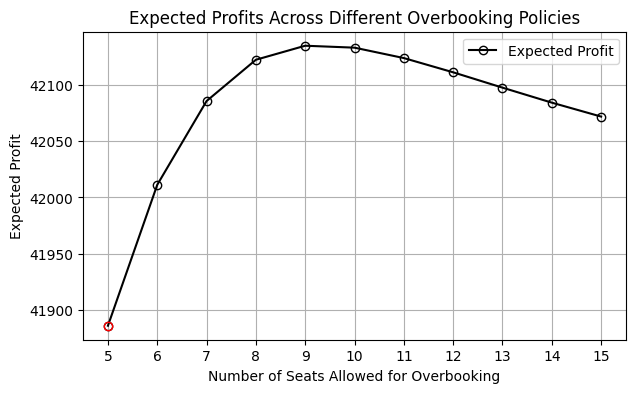

In [126]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 4))

# Plotting all points with hollow center and colored border
plt.plot(overbooking_values_policy1, expected_profits_policy1, '-o', mfc='none', mec='black', color='black', label='Expected Profit')

# Highlighting the point at overbooking = 5 with a red color
plt.plot(overbooking_values_policy1[0], expected_profits_policy1[0], 'o', mfc='none', mec='r')

plt.title('Expected Profits Across Different Overbooking Policies')
plt.xticks(np.arange(5, 16, 1))
plt.xlabel('Number of Seats Allowed for Overbooking')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()



Maximum profit at 9 seats too, and same value that previous policy. Beyond that, profits diverge, as higher overbooking costs kick in, underscoring the balance between first-class revenue and overbooking risks in profit optimization.

# **Simulation**

The provided code executes a detailed simulation of an airline's revenue management under different overbooking policies. It simulates the sale of tickets and the occurrence of passengers showing up on the day of departure, considering the probabilities associated with different pricing choices. By running multiple simulations (n_sim times), the code can statistically estimate expected revenues, costs associated with overbooking, and ultimately the profit for each flight.

Simulations like this are crucial because they incorporate variability and randomness inherent in customer behavior, providing a more robust and realistic estimate of financial outcomes under different strategies. By comparing simulations under various overbooking policies, the airline can empirically assess the impact of overbooking levels on profitability and make data-driven decisions to optimize its overbooking strategy.


In [78]:
def run_single_plane_sim(price_selection_policy, price_comb, prob_comb, overbooking):
    # initialize our plane
    coach_seats_sold = 0
    first_seats_sold = 0
    profit = 0
    revenue = 0
    overbooking_cost = 0

    # simulate each day
    for ti in range(T-1):
        # decide coach and first prices
        price_selection = int(price_selection_policy[coach_seats_sold][first_seats_sold][ti])

        # sell coach?
        if coach_seats_sold < coach_seats + overbooking:
            sold_coach = np.random.binomial(1,prob_comb[price_selection][0]) if first_seats_sold < first_seats else np.random.binomial(1,prob_comb[price_selection][0]+0.03)
        else:
            sold_coach = 0

        # sell first?
        if first_seats_sold < first_seats:
            sold_first = np.random.binomial(1,prob_comb[price_selection][1])
        else:
            sold_first = 0

        ### Validate with Dan if the discount should be in the simulation
        #                (sold coach * price coach day           +   sold first * price first of day)        * discounted of that day
        day_profit = (sold_coach*price_comb[price_selection][0] + sold_first*price_comb[price_selection][1]) * (daily_d**ti)
        coach_seats_sold += sold_coach
        first_seats_sold += sold_first
        revenue += day_profit

        # print(f'Day: {ti}, price_selection: {price_comb[price_selection]}, sold_coach: {sold_coach}, sold_first: {sold_first}, day_profit: {day_profit}, sum profit: {profit}')

    # day of plane depart show up simulation
    print('----------------------------------------------------------------------------------------------------------------------')
    print(f'Plane status, coach_tickets_sold: {coach_seats_sold}, first_tickets_sold: {first_seats_sold}')
    showup_coach = np.random.binomial(coach_seats_sold, coach_showup_prob)
    showup_first = np.random.binomial(first_seats_sold, first_showup_prob)
    profit = revenue

    # overbooking has occurred
    if showup_coach > coach_seats:
        overbook = showup_coach - coach_seats
        free_seats_first = first_seats - showup_first
        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

        # Value function = (cost of upgrading to first class + cost of bumping of the plane)
        overbooking_cost = (upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first))
        profit = revenue - overbooking_cost

    print(f'Plane status at take off, coach_showup: {showup_coach}, first_showup: {showup_first}, profit: {profit}')

    return coach_seats_sold, first_seats_sold, revenue, showup_coach, showup_first, overbooking_cost, profit

price_comb = np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H]])
prob_comb = np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob]])
run_single_plane_sim(pricing_policy[0], price_comb, prob_comb, 5)


----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 105, first_tickets_sold: 20
Plane status at take off, coach_showup: 100, first_showup: 19, profit: 42184.03768264043


(105, 20, 42184.03768264043, 100, 19, 0, 42184.03768264043)

**Simulating for both policies**

In [83]:

# Simulation Variables
n_sim = 5000
policies = [pricing_policy[4], pricing_policy_policy2[9]]
price_combs = [
    np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H]]),
    np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H], [0, first_price_L], [0, first_price_H]])
]
prob_combs = [
    np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob]]),
    np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob], [0, first_L_sale_prob], [0, first_H_sale_prob]])
]

# Initialize arrays to store simulation results for both policies
simulation_results = []

for policy_index, policy in enumerate(policies):
    sim_coach_seats_sold = np.zeros(n_sim)
    sim_first_seats_sold = np.zeros(n_sim)
    sim_revs = np.zeros(n_sim)
    sim_showup_coach = np.zeros(n_sim)
    sim_showup_first = np.zeros(n_sim)
    sim_overbook_cost = np.zeros(n_sim)
    sim_profits = np.zeros(n_sim)

    # Run the simulations
    for i in range(n_sim):
        sim_res = run_single_plane_sim(policy, price_combs[policy_index], prob_combs[policy_index], overbooking)
        sim_coach_seats_sold[i] = sim_res[0]
        sim_first_seats_sold[i] = sim_res[1]
        sim_revs[i] = sim_res[2]
        sim_showup_coach[i] = sim_res[3]
        sim_showup_first[i] = sim_res[4]
        sim_overbook_cost[i] = sim_res[5]
        sim_profits[i] = sim_res[6]

    # Store results for current policy
    simulation_results.append({
        'policy': policy_index,
        'coach_seats_sold': sim_coach_seats_sold,
        'first_seats_sold': sim_first_seats_sold,
        'revenues': sim_revs,
        'showup_coach': sim_showup_coach,
        'showup_first': sim_showup_first,
        'overbook_costs': sim_overbook_cost,
        'profits': sim_profits
    })

# At this point, simulation_results[0] contains the results for the first policy,
# and simulation_results[1] contains the results for the second policy.


Streaming output truncated to the last 5000 lines.
Plane status, coach_tickets_sold: 108, first_tickets_sold: 20
Plane status at take off, coach_showup: 105, first_showup: 20, profit: 40911.40564770343
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 20
Plane status at take off, coach_showup: 101, first_showup: 17, profit: 43648.46672953561
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 19
Plane status at take off, coach_showup: 106, first_showup: 19, profit: 41107.61230714329
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 105, first_tickets_sold: 20
Plane status at take off, coach_showup: 99, first_showup: 20, profit: 41620.2

Mean Revenue

In the context of the simulations, after running multiple scenarios, we calculate some important KPIs. First, we compute the average revenue across all simulations, providing insight into the expected earnings from ticket sales.

In [89]:
# Calculate and print mean revenues for both policies from the simulation_results structure
mean_revenue_policy1 = np.mean(simulation_results[0]['revenues'])
mean_revenue_policy2 = np.mean(simulation_results[1]['revenues'])

print(f"Mean Revenue for Policy 1: {mean_revenue_policy1}")
print(f"Mean Revenue for Policy 2: {mean_revenue_policy2}")

Mean Revenue for Policy 1: 42929.05782198351
Mean Revenue for Policy 2: 42911.50945364517


Average show-up rate for first-class passengers

In [90]:
# Calculate and print mean show-up rates for first-class passengers for both policies
mean_showup_first_policy1 = np.mean(simulation_results[0]['showup_first'])
mean_showup_first_policy2 = np.mean(simulation_results[1]['showup_first'])

print(f"Mean First-Class Show-up Rate for Policy 1: {mean_showup_first_policy1}")
print(f"Mean First-Class Show-up Rate for Policy 2: {mean_showup_first_policy2}")


Mean First-Class Show-up Rate for Policy 1: 19.021
Mean First-Class Show-up Rate for Policy 2: 19.0334


Overbooking Statistics - Number of times coach was overbooked

In [91]:
def calculate_overbooking_statistics(sim_showup_coach, coach_seats):
    overbooked_flights = sim_showup_coach > coach_seats
    num_overbooked_flights = np.sum(overbooked_flights)
    frequency_of_overbooking = num_overbooked_flights / len(sim_showup_coach)
    return num_overbooked_flights, frequency_of_overbooking

# Calculate overbooking statistics for Policy 1
num_overbooked_flights_policy1, frequency_of_overbooking_policy1 = calculate_overbooking_statistics(
    simulation_results[0]['showup_coach'], coach_seats
)

# Calculate overbooking statistics for Policy 2
num_overbooked_flights_policy2, frequency_of_overbooking_policy2 = calculate_overbooking_statistics(
    simulation_results[1]['showup_coach'], coach_seats
)

# Print the overbooking statistics for both policies
print(f"Policy 1 - Number of times coach was overbooked: {num_overbooked_flights_policy1}, Frequency: {frequency_of_overbooking_policy1}")
print(f"Policy 2 - Number of times coach was overbooked: {num_overbooked_flights_policy2}, Frequency: {frequency_of_overbooking_policy2}")


Policy 1 - Number of times coach was overbooked: 3979, Frequency: 0.7958
Policy 2 - Number of times coach was overbooked: 3983, Frequency: 0.7966


Overbooking Statistics - Average and Volatility of overbooking costs

In [93]:
import numpy as np

def calculate_policy_metrics(simulation_results):
    metrics_results = []
    for result in simulation_results:
        average_overbooking_cost = np.mean(result['overbook_costs'])
        overbooking_cost_std_dev = np.std(result['overbook_costs'])
        metrics_results.append({
            'policy': result['policy'] + 1,  # Adjusting index to human-readable format
            'average_overbooking_cost': average_overbooking_cost,
            'overbooking_cost_std_dev': overbooking_cost_std_dev
        })
    return metrics_results

# Assuming your simulation_results array is already populated with the results from running your simulations
metrics_results = calculate_policy_metrics(simulation_results)

for result in metrics_results:
    print(f"Policy {result['policy']} Average overbooking cost: {result['average_overbooking_cost']:.2f}")
    print(f"Policy {result['policy']} Volatility of overbooking cost (Standard Deviation): {result['overbooking_cost_std_dev']:.2f}\n")


Policy 1 Average overbooking cost: 939.19
Policy 1 Volatility of overbooking cost (Standard Deviation): 871.42

Policy 2 Average overbooking cost: 962.73
Policy 2 Volatility of overbooking cost (Standard Deviation): 881.60



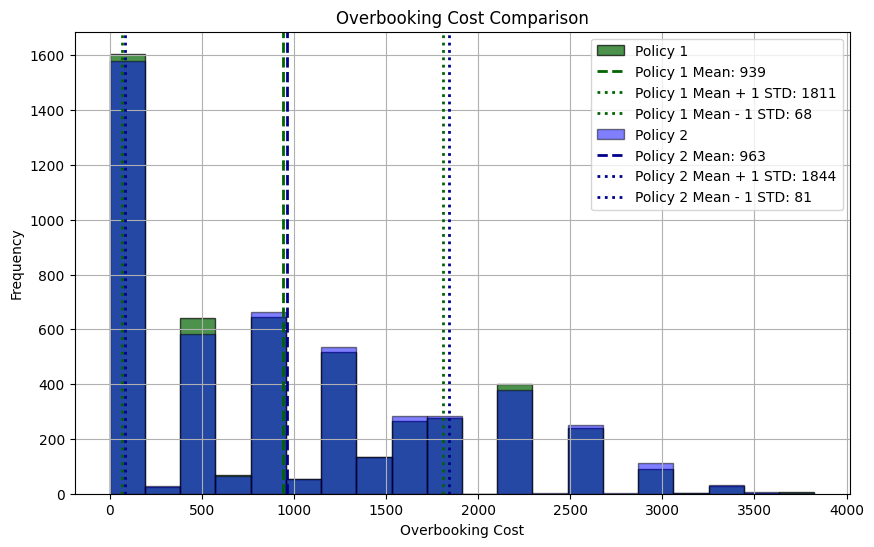

In [119]:
def plot_metric_comparison(data_policy1, data_policy2, title, xlabel, ylabel, color1='darkgreen', color2='blue'):
    plt.figure(figsize=(10, 6))

    # Calculate means and standard deviations
    mean1, std_dev1 = np.mean(data_policy1), np.std(data_policy1)
    mean2, std_dev2 = np.mean(data_policy2), np.std(data_policy2)

    # Histogram for Policy 1
    plt.hist(data_policy1, bins=20, alpha=0.7, color=color1, edgecolor='black', label='Policy 1')
    plt.axvline(mean1, color='darkgreen', linestyle='--', linewidth=2, label=f'Policy 1 Mean: {mean1:.0f}')
    plt.axvline(mean1 + std_dev1, color='darkgreen', linestyle=':', linewidth=2, label=f'Policy 1 Mean + 1 STD: {mean1 + std_dev1:.0f}')
    plt.axvline(mean1 - std_dev1, color='darkgreen', linestyle=':', linewidth=2, label=f'Policy 1 Mean - 1 STD: {mean1 - std_dev1:.0f}')

    # Histogram for Policy 2
    plt.hist(data_policy2, bins=20, alpha=0.5, color=color2, edgecolor='black', label='Policy 2')
    plt.axvline(mean2, color='darkblue', linestyle='--', linewidth=2, label=f'Policy 2 Mean: {mean2:.0f}')
    plt.axvline(mean2 + std_dev2, color='darkblue', linestyle=':', linewidth=2, label=f'Policy 2 Mean + 1 STD: {mean2 + std_dev2:.0f}')
    plt.axvline(mean2 - std_dev2, color='darkblue', linestyle=':', linewidth=2, label=f'Policy 2 Mean - 1 STD: {mean2 - std_dev2:.0f}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Overbooking Costs
plot_metric_comparison(
    data_policy1=simulation_results[0]['overbook_costs'],
    data_policy2=simulation_results[1]['overbook_costs'],
    title='Overbooking Cost Comparison',
    xlabel='Overbooking Cost',
    ylabel='Frequency'
)



Average and Volatility of Profits

In [101]:
import numpy as np

def analyze_policy_profits(simulation_results):
    profit_analysis_results = []
    for result in simulation_results:
        average_profit = np.mean(result['profits'])
        profit_std_dev = np.std(result['profits'])
        profit_analysis_results.append({
            'policy': result['policy'] + 1,  # Making policy numbering human-friendly
            'average_profit': average_profit,
            'profit_std_dev': profit_std_dev
        })
    return profit_analysis_results

# Assuming your simulation_results array is populated with the results from your simulations
profit_analysis_results = analyze_policy_profits(simulation_results)

for result in profit_analysis_results:
    print(f"Policy {result['policy']} Average profit: {result['average_profit']:.0f}")
    print(f"Policy {result['policy']} Volatility of profits (Standard Deviation): {result['profit_std_dev']:.0f}\n")


Policy 1 Average profit: 41990
Policy 1 Volatility of profits (Standard Deviation): 974

Policy 2 Average profit: 41949
Policy 2 Volatility of profits (Standard Deviation): 997



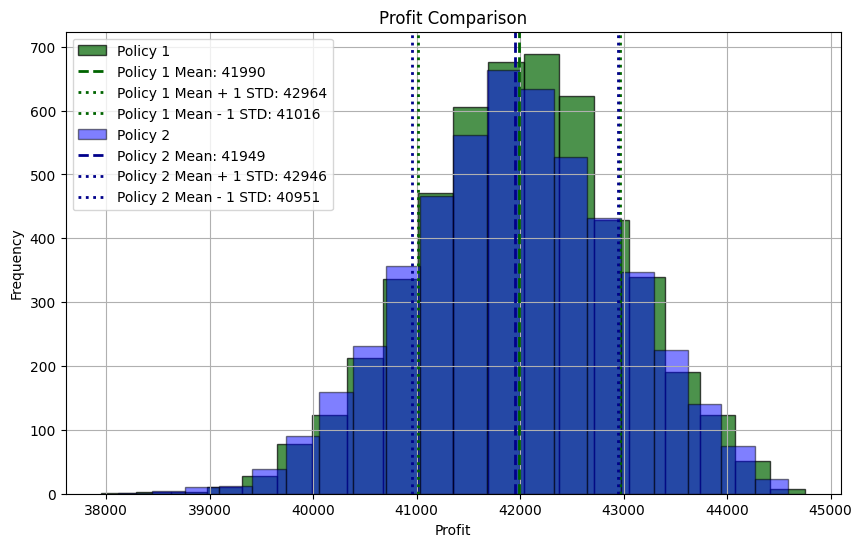

In [120]:
# Plot for Profits
plot_metric_comparison(
    data_policy1=simulation_results[0]['profits'],
    data_policy2=simulation_results[1]['profits'],
    title='Profit Comparison',
    xlabel='Profit',
    ylabel='Frequency'
)

Profit Per Seat

In [103]:
def profit_per_seat(sim_profits, sim_coach_seats_sold, sim_first_seats_sold):
    # Calculates profit per seat for each simulation
    total_seats_sold = sim_coach_seats_sold + sim_first_seats_sold
    profits_per_seat = sim_profits / total_seats_sold
    return profits_per_seat


In [122]:
profits_per_seat_policy1 = profit_per_seat(simulation_results[0]['profits'], simulation_results[0]['coach_seats_sold'], simulation_results[0]['first_seats_sold'])
profits_per_seat_policy2 = profit_per_seat(simulation_results[1]['profits'], simulation_results[1]['coach_seats_sold'], simulation_results[1]['first_seats_sold'])

average_profit_per_seat_policy1 = sum(profits_per_seat_policy1) / len(profits_per_seat_policy1)
average_profit_per_seat_policy2 = sum(profits_per_seat_policy2) / len(profits_per_seat_policy2)

print("Average Profit Per Seat for Policy 1:", average_profit_per_seat_policy1)
print("Average Profit Per Seat for Policy 2:", average_profit_per_seat_policy2)

Average Profit Per Seat for Policy 1: 329.0205219108501
Average Profit Per Seat for Policy 2: 328.710276918661


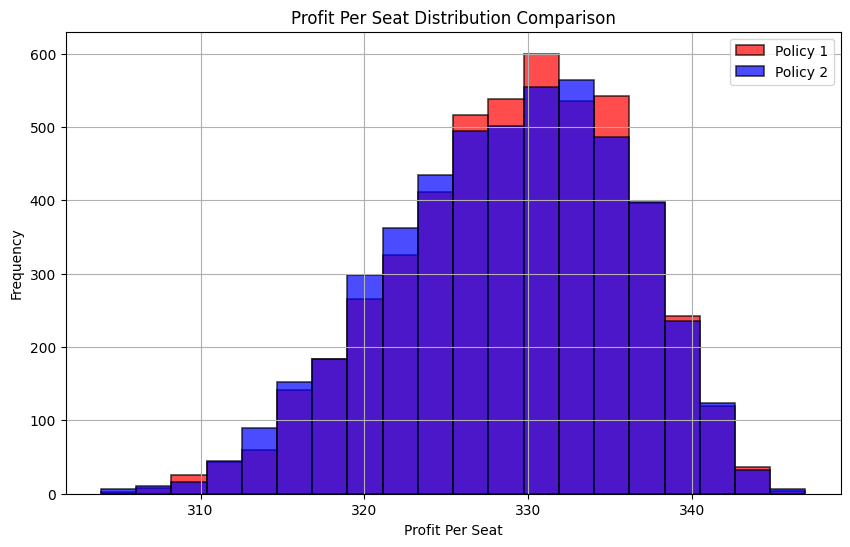

In [110]:
def plot_histogram_comparison(data1, data2, title, xlabel, ylabel, colors=['red', 'blue'], labels=['Policy 1', 'Policy 2']):
    plt.figure(figsize=(10, 6))
    bins = np.histogram_bin_edges(data1, bins=20)  # Ensures both histograms use the same bins for a fair comparison
    plt.hist(data1, bins=bins, alpha=0.7, color=colors[0], label=labels[0], edgecolor='black', linewidth=1.2, fill=True)
    plt.hist(data2, bins=bins, alpha=0.7, color=colors[1], label=labels[1], edgecolor='black', linewidth=1.2, fill=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)  # Adding grid for better readability
    plt.show()

# Assuming you've already calculated profits_per_seat_policy1 and profits_per_seat_policy2
# Plotting the comparison with specified colors
plot_histogram_comparison(
    profits_per_seat_policy1,
    profits_per_seat_policy2,
    'Profit Per Seat Distribution Comparison',
    'Profit Per Seat',
    'Frequency',
    colors=['red', 'blue']
)
